In [85]:
import importlib
from hcdp import hcdp
importlib.reload(hcdp)
import numpy as np

# test = hcdp.FileDownloadAPI('rainfall', year=2020, month=4)
# test.download_file('test.tif')
# dataset = test.get_data()
# test.plot_raster()

# dataset.crs


# getting data for a full year

c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanc

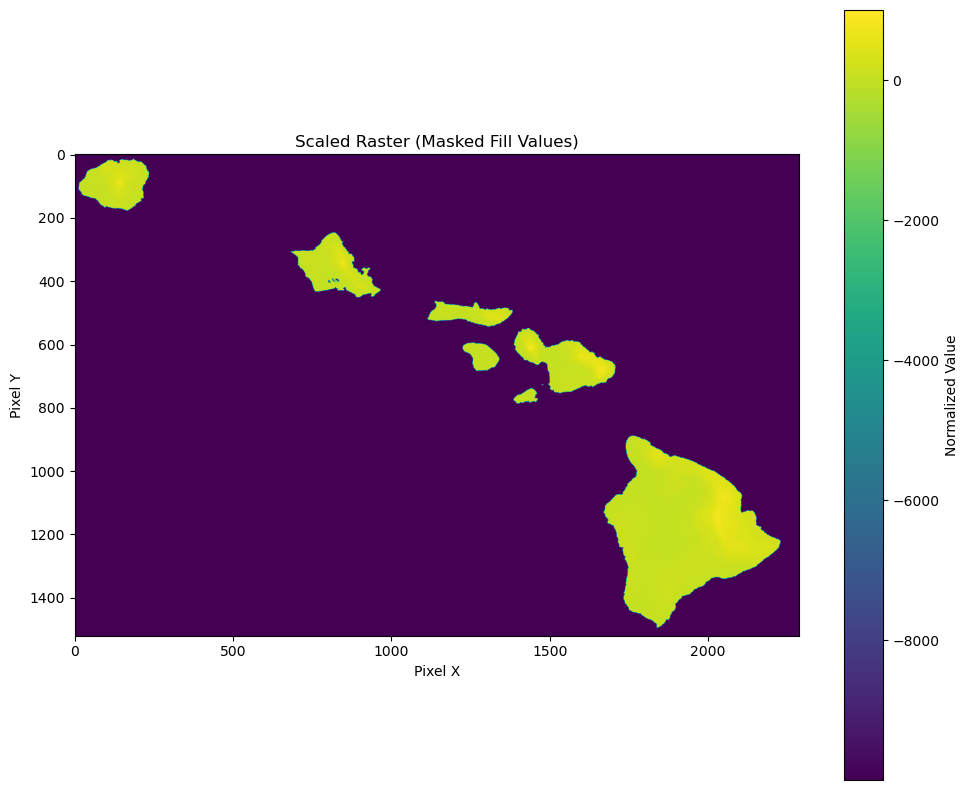

In [87]:
dataset = hcdp.get_year_avg('rainfall', 2015)
hcdp.plot_raster_band(dataset)


In [72]:
dst

<closed DatasetWriter name='mean_image.tif' mode='w'>

In [65]:
from rasterio.warp import transform_bounds
with rasterio.open("test.tif") as dataset:
    # Read the raster data into a NumPy array
    raster_data = dataset.read(1)  # Assuming single-band data
    raster_data_normalized = raster_data / raster_data.max()  # Normalize values for visualization

    # Transform bounds to WGS84 (EPSG:4326)
    bounds = transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)

In [64]:
bounds

(-159.816, 18.849, -154.668, 22.269)

In [52]:
dataset.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [16]:
np.unique(dataset.read(1))

array([-3.4000000e+38,  2.0339863e+01,  2.0370369e+01, ...,
        9.6138696e+02,  9.6307141e+02,  9.9695148e+02], dtype=float32)

In [10]:
import numpy as np
np.unique(dataset.read(1))

array([-3.4000000e+38,  2.0339863e+01,  2.0370369e+01, ...,
        9.6138696e+02,  9.6307141e+02,  9.9695148e+02], dtype=float32)

In [2]:
import requests

def download_rainfall_data(production, period, extent, fill, filetype, year, month, day=None, output_filename='rainfall_data'):
    base_url = "https://ikeauth.its.hawaii.edu/files/v2/download/public/system/ikewai-annotated-data/HCDP/production/rainfall"
    
    # Construct the URL
    url = f"{base_url}/{production}/{period}/{extent}/{fill}/{filetype}/{year}/{month}/rainfall_{production}_{period}_{extent}_{fill}_{filetype}_{year}_{month}"
    
    if day:
        url += f"_{day}"
    
    url += f".{filetype}"
    
    # Send the GET request (no authentication required)
    response = requests.get(url, verify=False)  # verify=False if you want to ignore SSL verification
    
    if response.status_code == 200:
        # Save the content to a file
        with open(output_filename, 'wb') as f:
            f.write(response.content)
        print(f"Data downloaded successfully: {output_filename}")
    else:
        print(f"Failed to download data. HTTP Status code: {response.status_code}")

# Example usage
download_rainfall_data(
    production="new",
    period="month",
    extent="statewide",
    fill="partial",
    filetype="tif",
    year="2012",
    month="03",
    day=None,  # Optional
    output_filename="rainfall_data_2012_03.tif"
)


c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Failed to download data. HTTP Status code: 404


In [3]:
import requests

def download_rainfall_file(url, output_filename):
    # Send the GET request to download the file
    response = requests.get(url, verify=False)  # verify=False if you want to ignore SSL verification
    
    if response.status_code == 200:
        # Save the file content to the specified output filename
        with open(output_filename, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully: {output_filename}")
    else:
        print(f"Failed to download file. HTTP Status code: {response.status_code}")

# Example: Construct the URL and download the file
url = "https://ikeauth.its.hawaii.edu/files/v2/download/public/system/ikewai-annotated-data/HCDP/production/rainfall/new/month/statewide/data_map/2012/rainfall_new_month_statewide_data_map_2012_03.tif"
output_filename = "rf_test.tif"

download_rainfall_file(url, output_filename)


c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File downloaded successfully: rf_test.tif
